In [79]:
# !python -V

In [80]:
# !pip install pyarrow
# pip freeze requirements.txt
# pip install -r requirements.txt

In [81]:
# mlflow ui --backend-store-uri sqlite:///mlflow.db
# mlflow db upgrade "sqlite:///mlflow.db"

In [82]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# import mlflow
# from flask_sqlalchemy import SQLAlchemy

import warnings
warnings.filterwarnings('ignore')

In [83]:
# import sqlalchemy
import mlflow

In [84]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("mlflow-tracking")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='mlflow-tracking', tags={}>

In [85]:
df = pd.read_parquet('../../data/green_tripdata_2021-01.parquet')

In [86]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [87]:
df.shape

(76518, 20)

In [88]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [89]:
df[['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration']].head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,0 days 00:00:04


In [90]:
td = df.duration.iloc[0]
td.total_seconds() / 60

3.933333333333333

In [91]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [92]:
df[['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'duration']].head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,0.066667


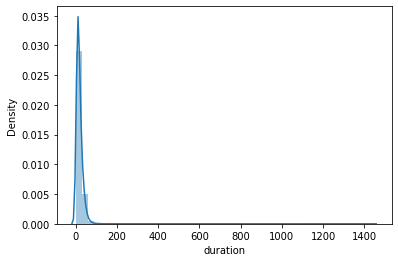

In [93]:
sns.distplot(df.duration)
plt.show()

In [94]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [95]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [96]:
((df.duration >=1) & (df.duration <=60)).mean()

0.9658903787344154

In [97]:
df = df[(df.duration >=1) & (df.duration <=60)]

In [98]:
df.shape

(73908, 21)

In [99]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [100]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts[:5]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45}]

In [101]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [102]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [103]:
target = 'duration'
y_train = df[target].values

In [104]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464089077113

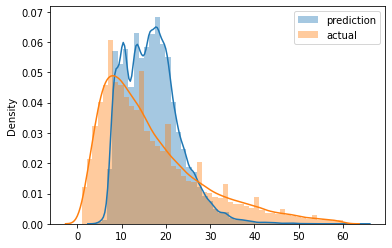

In [105]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [106]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [107]:
df_train = read_dataframe('../../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../../data/green_tripdata_2021-02.parquet')

In [108]:
print(df_train.shape)
print(df_val.shape)

(73908, 21)
(61921, 21)


In [109]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [110]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [111]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
print(train_dicts[:5])

print('*'*20)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
print(val_dicts[:5])

[{'PU_DO': '43_151', 'trip_distance': 1.01}, {'PU_DO': '166_239', 'trip_distance': 2.53}, {'PU_DO': '41_42', 'trip_distance': 1.12}, {'PU_DO': '168_75', 'trip_distance': 1.99}, {'PU_DO': '75_75', 'trip_distance': 0.45}]
********************
[{'PU_DO': '130_205', 'trip_distance': 3.66}, {'PU_DO': '152_244', 'trip_distance': 1.1}, {'PU_DO': '152_48', 'trip_distance': 4.93}, {'PU_DO': '152_241', 'trip_distance': 6.7}, {'PU_DO': '75_42', 'trip_distance': 1.89}]


In [112]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [113]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [114]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.479602100230243

In [115]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [116]:
with mlflow.start_run():
    
    mlflow.set_tag("Data scientist", "Athiq")
    mlflow.log_param("train-path", "data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-path", "data/green_tripdata_2021-02.parquet")

    alpha = 0.01

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse", rmse)